# **Лабораторная работа №1**
# **Разведочный анализ данных. Исследование и  визуализация данных (EDA)**

## Выполнил: Дюжев Степан ИУ5Ц-83Б


## Подготовка

Выполним импорт необходимых библиотек

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

plt.style.use('bmh')

Импортируем данные из датасета

In [2]:
df = pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Просмотрим информацию о столбцах

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Мы можем заметить, что в некоторых столбцах очень много NaN значений, при анализе такие столбцы не релевантны, поэтому мы удалим их

удалим столбец id так как он не несет никаой полезной для исследования информации

In [4]:
del df["Id"]

In [5]:
# df.count() не включате NaN значения
df2 = df[[column for column in df if df[column].count() / len(df) >= 0.3]]
print("List of dropped columns:", end=" ")
for c in df.columns:
    if c not in df2.columns:
        print(c, end=", ")
print('\n')
df = df2

List of dropped columns: Alley, PoolQC, Fence, MiscFeature, 



Теперь давайте посмотрим, как распределяются цены на жилье

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


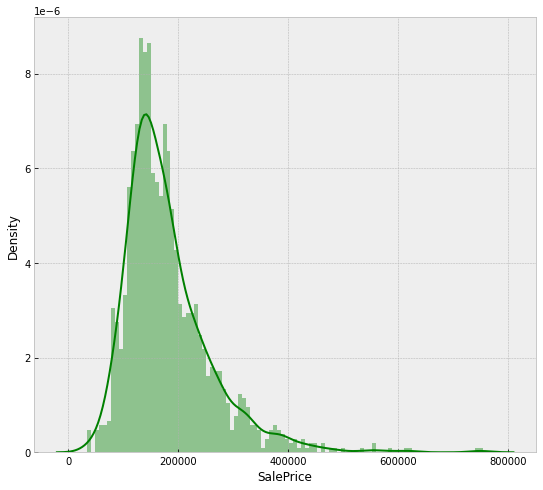

In [6]:
print(df['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

С помощью этой информации мы видим, что цены искажены вправо, а некоторые выбросы лежат выше ~500 000. В конце концов мы захотим избавиться от них, чтобы получить нормальное распределение независимой переменной (`SalePrice`) исследования


## Распределение числовых данных

рассмотрим распределение всех функций путем их построения

Для этого давайте сначала перечислим все типы наших данных из нашего набора данных и возьмем только числовые:

In [7]:
list(set(df.dtypes.tolist()))

[dtype('float64'), dtype('int64'), dtype('O')]

In [8]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000


Построим графики

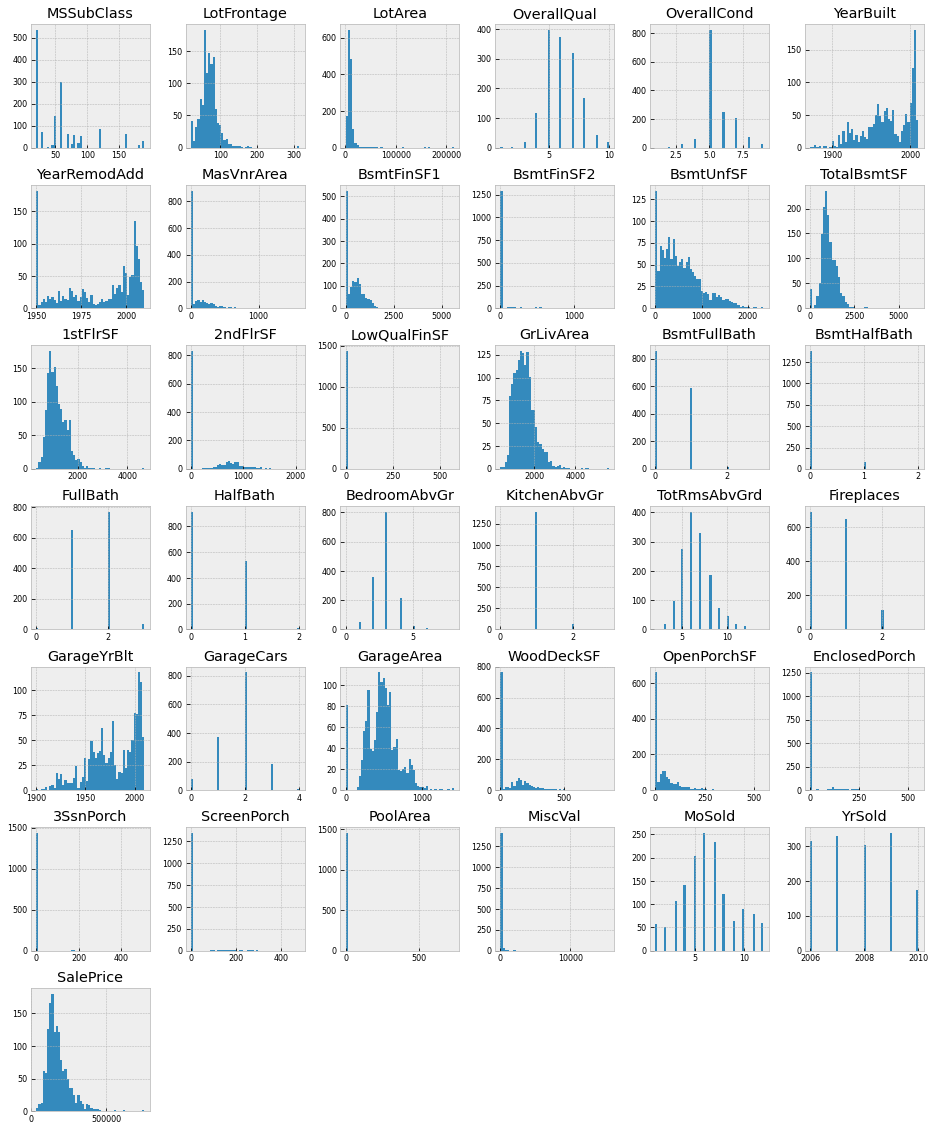

In [9]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

#### Корреляция признаков

Теперь мы попытаемся найти, какие функции сильно коррелируют с SalePrice. Мы будем хранить их в списке под названием golden_features_list. Для этого мы повторно используем наш набор данных df_num.

In [10]:
df_num_corr = df_num.corr()['SalePrice'][:-1] # -1 потому что последний столбец и есть SalePrice
golden_features_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print("{} сильно коррелирущих признаков с SalePrice:\n{}".format(len(golden_features_list), golden_features_list))

10 сильно коррелирущих признаков с SalePrice:
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


Теперь у нас есть список сильно коррелированных значений, но этот список неполон, поскольку мы знаем, что на корреляцию влияют выбросы.
- Построим график числовых характеристик и посмотрим, какие из них имеют очень мало выбрасов и их можно объяснить
- Удалим выбросы из этих функций и посмотрим, какие из них могут иметь хорошую корреляцию без выбросов

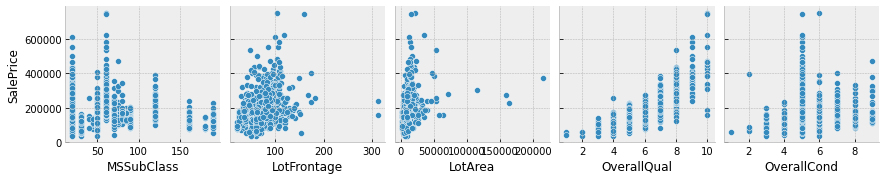

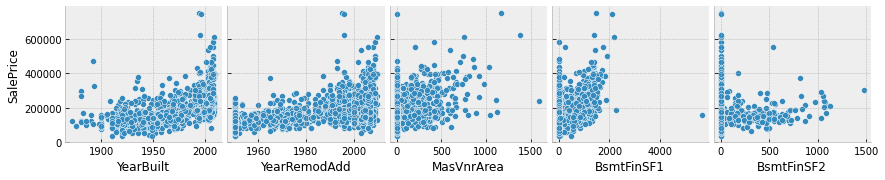

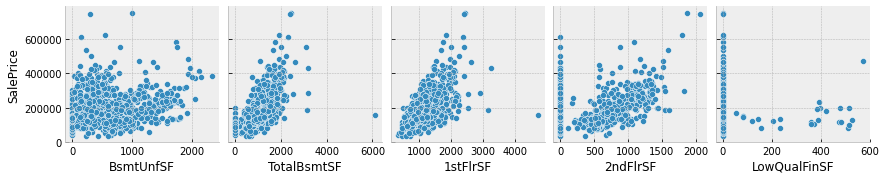

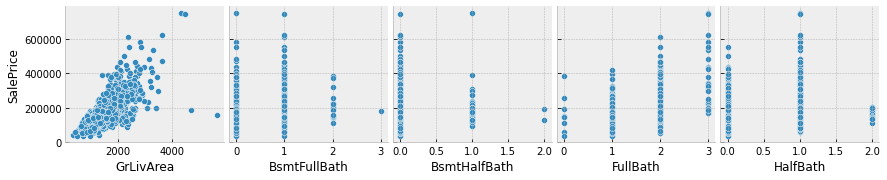

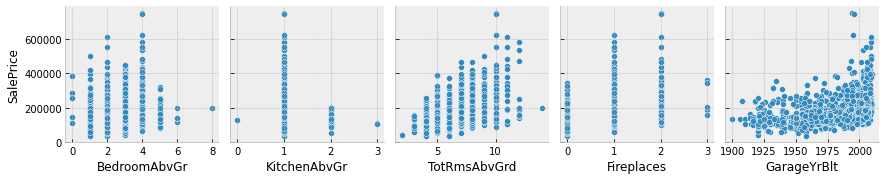

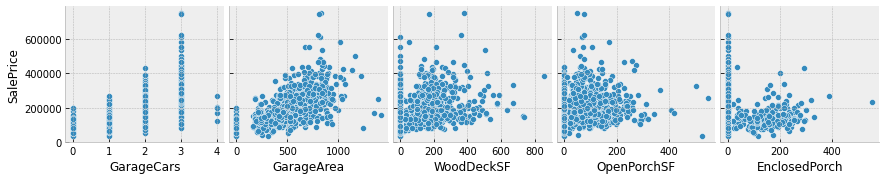

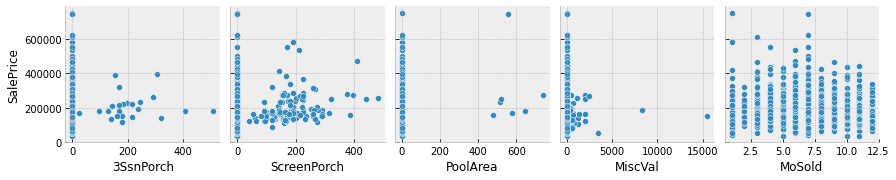

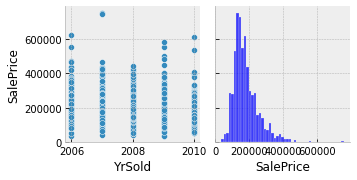

In [11]:
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['SalePrice'])

Можем определить некоторые отношения, большинство из них, по-видимому, имеют линейную связь с "SalePrice", и если мы внимательно посмотрим на данные, то увидим, что многие точки данных расположены на "x = 0", что может указывать на отсутствие такого признака в доме.

давайте удалим эти значения и повторим процесс поиска коррелированных значений заново

In [12]:
import operator

individual_features_df = []
for i in range(0, len(df_num.columns) - 1): # -1 потому что последний столбец и есть SalePrice
    tmpDf = df_num[[df_num.columns[i], 'SalePrice']]
    tmpDf = tmpDf[tmpDf[df_num.columns[i]] != 0]
    individual_features_df.append(tmpDf)

all_correlations = {feature.columns[0]: feature.corr()['SalePrice'][0] for feature in individual_features_df}
all_correlations = sorted(all_correlations.items(), key=operator.itemgetter(1))
for (key, value) in all_correlations:
    print("{:>15}: {:>15}".format(key, value))

   KitchenAbvGr: -0.13920069217785566
       HalfBath: -0.08439171127179887
     MSSubClass: -0.08428413512659523
    OverallCond: -0.0778558940486776
         YrSold: -0.028922585168730426
   BsmtHalfBath: -0.028834567185481712
       PoolArea: -0.014091521506356928
   BsmtFullBath: 0.011439163340408634
         MoSold: 0.04643224522381936
      3SsnPorch: 0.06393243256889079
    OpenPorchSF: 0.08645298857147708
        MiscVal: 0.08896338917298924
     Fireplaces: 0.1216605842136395
      BsmtUnfSF: 0.16926100049514192
   BedroomAbvGr: 0.18093669310849045
     WoodDeckSF: 0.19370601237520677
     BsmtFinSF2: 0.19895609430836586
  EnclosedPorch: 0.2412788363011751
    ScreenPorch: 0.25543007954878405
        LotArea: 0.2638433538714063
   LowQualFinSF: 0.3000750165550133
    LotFrontage: 0.35179909657067854
     MasVnrArea: 0.4340902197568926
     BsmtFinSF1: 0.4716904265235731
    GarageYrBlt: 0.48636167748786213
   YearRemodAdd: 0.5071009671113867
      YearBuilt: 0.5228973328794967

Мы нашли еще одно сильно коррелированное значение, немного очистив данные. Теперь golden_features_list выглядит так:

In [13]:
golden_features_list = [key for key, value in all_correlations if abs(value) >= 0.5]
print("There is {} strongly correlated values with SalePrice:\n{}".format(len(golden_features_list), golden_features_list))

There is 11 strongly correlated values with SalePrice:
['YearRemodAdd', 'YearBuilt', 'TotRmsAbvGrd', 'FullBath', '1stFlrSF', 'GarageArea', 'TotalBsmtSF', 'GarageCars', '2ndFlrSF', 'GrLivArea', 'OverallQual']


### Заключение

Изучая корреляцию между числовыми значениями, мы обнаружили 11 признаков, которые имеют сильную связь с ценой дома. Кроме корреляции, мы не нашли никакой заметной закономерности на данных, которые не коррелируют.

## Отношение объекта к объекту

Попытка изобразить все числовые характеристики на парном графике pairplot займет у нас слишком много времени и будет трудно интерпретировать. Мы можем попытаться увидеть, связаны ли некоторые переменные между собой, а затем объяснить их связь с помощью здравого смысла.

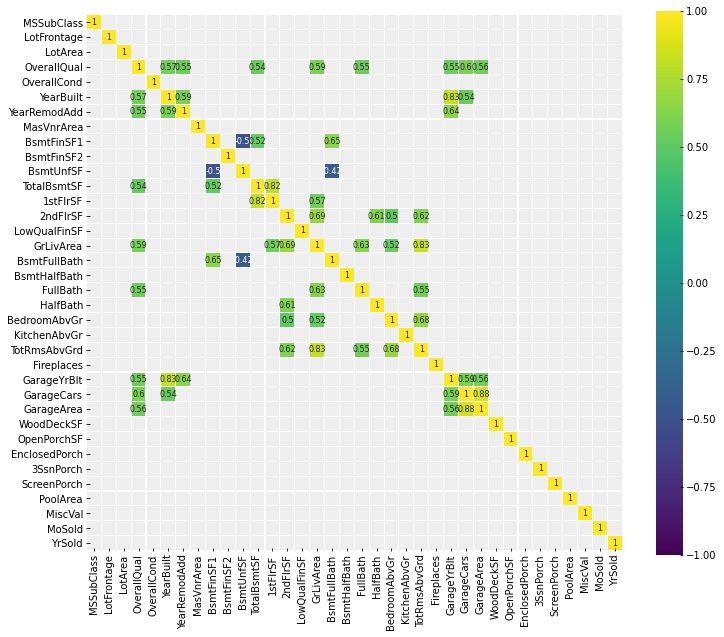

In [ ]:
corr = df_num.drop('SalePrice', axis=1).corr() # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

## Q -> Q (количественные связи)

In [14]:
quantitative_features_list = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF',
    '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
    'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
    'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']
df_quantitative_values = df[quantitative_features_list]
df_quantitative_values.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
0,65.0,8450,196.0,706,0,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,208500
1,80.0,9600,0.0,978,0,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,181500
2,68.0,11250,162.0,486,0,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,223500
3,60.0,9550,0.0,216,0,756,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0,140000
4,84.0,14260,350.0,655,0,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,250000


In [15]:
features_to_analyse = [x for x in quantitative_features_list if x in golden_features_list]
features_to_analyse.append('SalePrice')
features_to_analyse

['TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageCars',
 'GarageArea',
 'SalePrice']

распределение


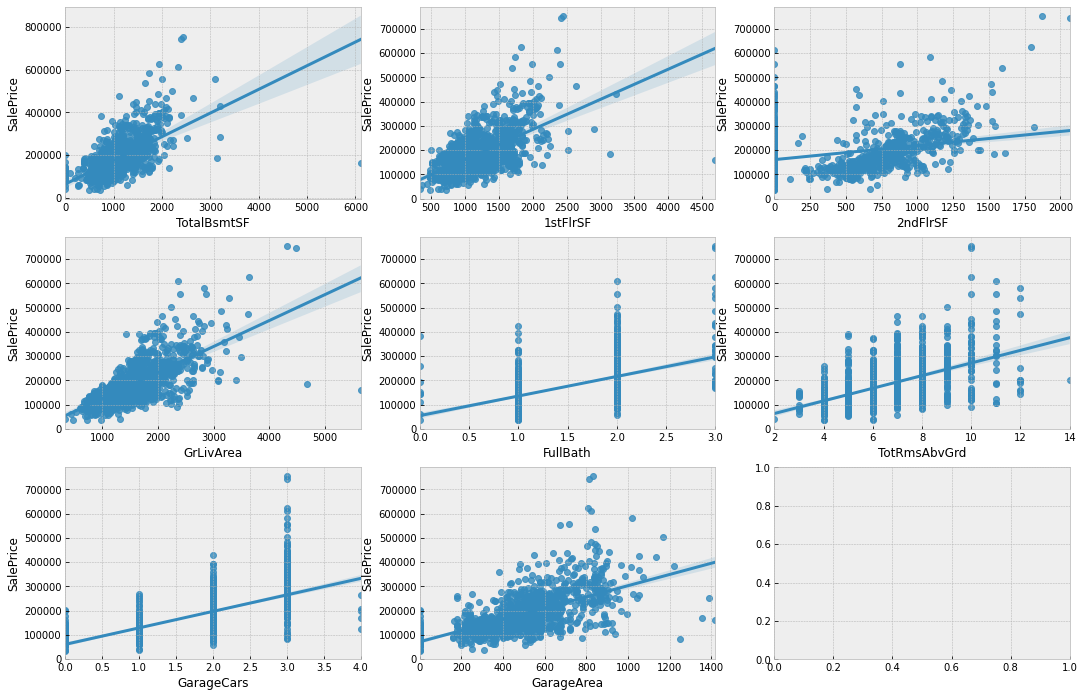

In [ ]:
fig, ax = plt.subplots(round(len(features_to_analyse) / 3), 3, figsize = (18, 12))

for i, ax in enumerate(fig.axes):
    if i < len(features_to_analyse) - 1:
        sns.regplot(x=features_to_analyse[i],y='SalePrice', data=df[features_to_analyse], ax=ax)

такие функции, как `TotalBsmtSF`,` 1stFlrSF`, `GrLivArea`, имеют большой разброс

## C -> Q (Отношение категориального к количественному)

In [16]:
# quantitative_features_list[:-1] as the last column is SalePrice and we want to keep it
categorical_features = [a for a in quantitative_features_list[:-1] + df.columns.tolist() if (a not in quantitative_features_list[:-1]) or (a not in df.columns.tolist())]
df_categ = df[categorical_features]
df_categ.head()

,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PavedDrive,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,150,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,2003.0,RFn,TA,TA,Y,2,2008,WD,Normal,208500
1,20,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,284,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,1976.0,RFn,TA,TA,Y,5,2007,WD,Normal,181500
2,60,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,434,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,2001.0,RFn,TA,TA,Y,9,2008,WD,Normal,223500
3,70,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,540,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,1998.0,Unf,TA,TA,Y,2,2006,WD,Abnorml,140000
4,60,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,490,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,2000.0,RFn,TA,TA,Y,12,2008,WD,Normal,250000


In [17]:
df_not_num = df_categ.select_dtypes(include = ['O'])
print('There is {} non numerical features including:\n{}'.format(len(df_not_num.columns), df_not_num.columns.tolist()))

There is 39 non numerical features including:
['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

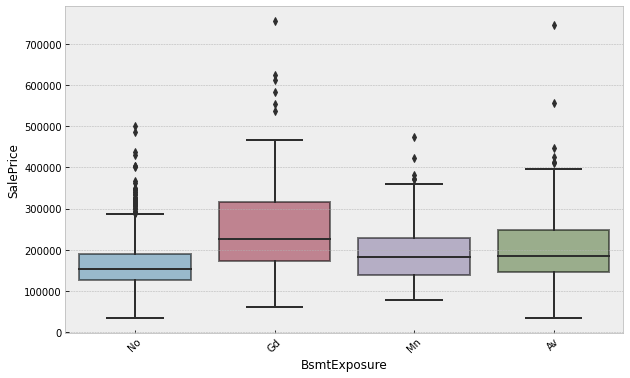

In [18]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='BsmtExposure', y='SalePrice', data=df_categ)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

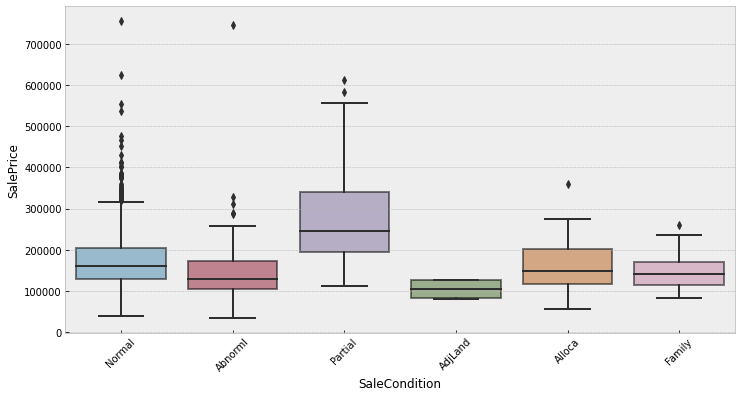

In [19]:
plt.figure(figsize = (12, 6))
ax = sns.boxplot(x='SaleCondition', y='SalePrice', data=df_categ)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

Посмотрим на их распределение

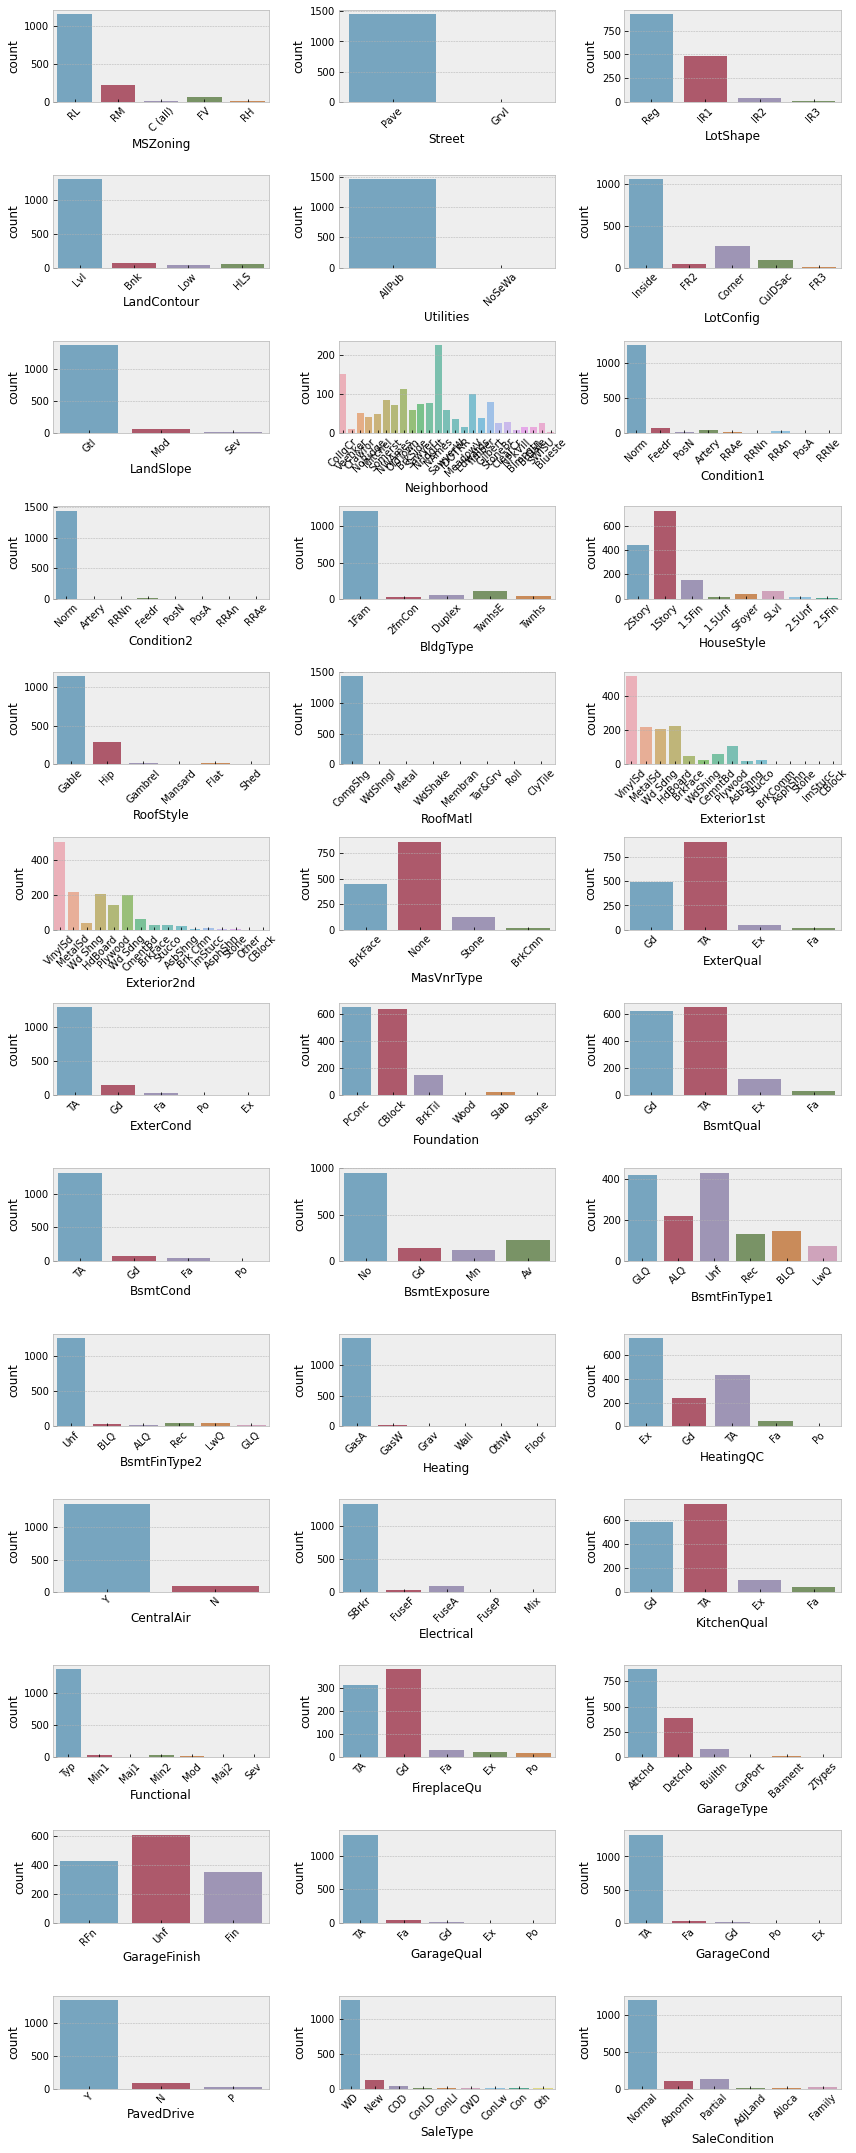

In [20]:
fig, axes = plt.subplots(round(len(df_not_num.columns) / 3), 3, figsize=(12, 30))

for i, ax in enumerate(fig.axes):
    if i < len(df_not_num.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=df_not_num.columns[i], alpha=0.7, data=df_not_num, ax=ax)

fig.tight_layout()